In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import confusion_matrix
import numpy as np
import random

C:\Users\patry\AppData\Local\Temp\ipykernel_24180\4154456330.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
def plot_CIFAR10():
    plt.figure(figsize = (10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        random_index = random.randint(0, len(train_images) - 1)
        plt.imshow(train_images[random_index])
        plt.xlabel(class_names[train_labels[random_index][0]])
    plt.show()

def plot_missclassified(Y_pred):
    misclassified_indices = []
    for i in range(len(Y_pred)):
        if test_labels[i] != Y_pred[i]:
            misclassified_indices.append(i)

    num_samples = 5
    random_misclassified_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

    plt.figure(figsize = (20, 5))
    for i, idx in enumerate(random_misclassified_indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(test_images[idx])
        plt.title(f"True: {class_names[test_labels[idx][0]]}, Predicted: {class_names[Y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_cofusion_matrix(mat):
    plt.figure(figsize = (16, 9))

    ind_array = np.arange(len(class_names))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = mat[x_val][y_val]
        color = 'black' if c > 400 else 'red'
        plt.text(x_val, y_val, c, va = 'center', ha = 'center', color = color)
        
    plt.rc("xtick", labelsize = 15)
    plt.rc("ytick", labelsize = 15)
    plt.xticks(range(0, 10))
    plt.yticks(range(0, 10))
    plt.title('Confusion matrix', fontsize = 20)
    plt.imshow(mat)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize = (16, 9))
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.title('Training and validation accuracy', fontsize = 20)
    plt.xlabel('Epochs', fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.legend()
    plt.grid()
    plt.show()

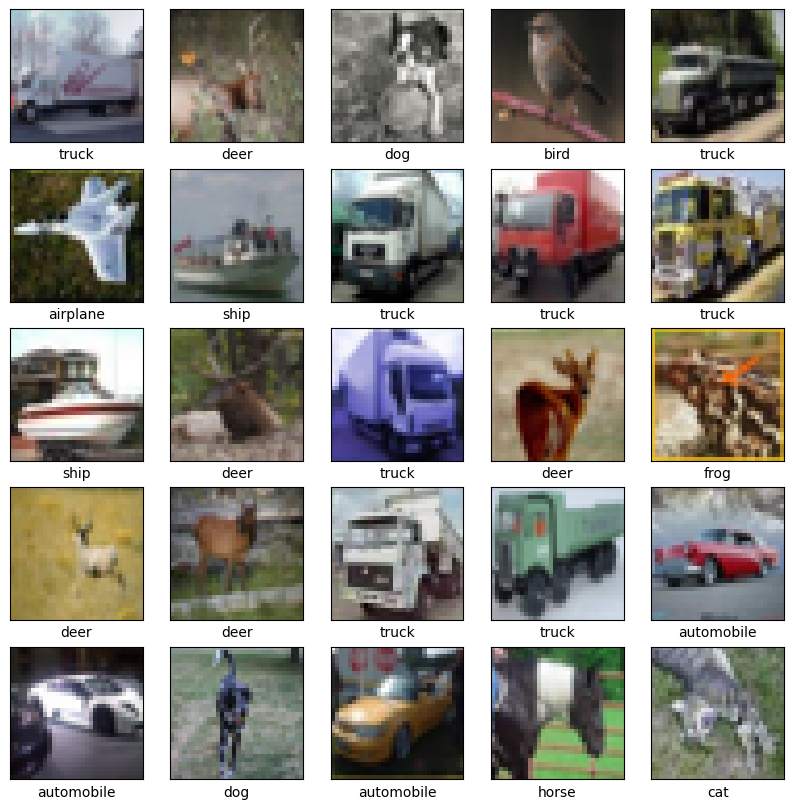

In [4]:
plot_CIFAR10()

In [5]:
all_images = np.concatenate((train_images, test_images))
all_labels = np.concatenate((train_labels, test_labels))

num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype = int)

for label in all_labels:
    class_counts[label[0]] += 1

for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} images")

airplane: 6000 images
automobile: 6000 images
bird: 6000 images
cat: 6000 images
deer: 6000 images
dog: 6000 images
frog: 6000 images
horse: 6000 images
ship: 6000 images
truck: 6000 images


In [6]:
def build_model(type, stride):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides = (stride, stride), padding = type, activation = 'relu', input_shape = (32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2), (2, 2)))
    model.add(layers.Conv2D(64, (3, 3), strides = (stride, stride), padding = type, activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2), (2, 2)))
    model.add(layers.Conv2D(128, (3, 3), strides = (stride, stride), padding = type, activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))
    return model

In [7]:
type1 = 'same'
type2 = 'valid'
stride1 = 1
stride2 = 2

c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,250 (2.36 MB)

 Trainable params: 618,250 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.2684 - loss: 1.9274 - val_accuracy: 0.5143 - val_loss: 1.3839
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4652 - loss: 1.4599 - val_accuracy: 0.5907 - val_loss: 1.1585
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5431 - loss: 1.2615 - val_accuracy: 0.6465 - val_loss: 0.9986
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.6022 - loss: 1.1178 - val_accuracy: 0.6879 - val_loss: 0.9236
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.6415 - loss: 1.0088 - val_accuracy: 0.6976 - val_loss: 0.8999
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6742 - loss: 0.9337 - val_accuracy: 0.7045 - val_loss: 0.8547
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.6983 - loss: 0.8558 - val_accuracy: 0.7174 - val_loss: 0.8152
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.7204 -

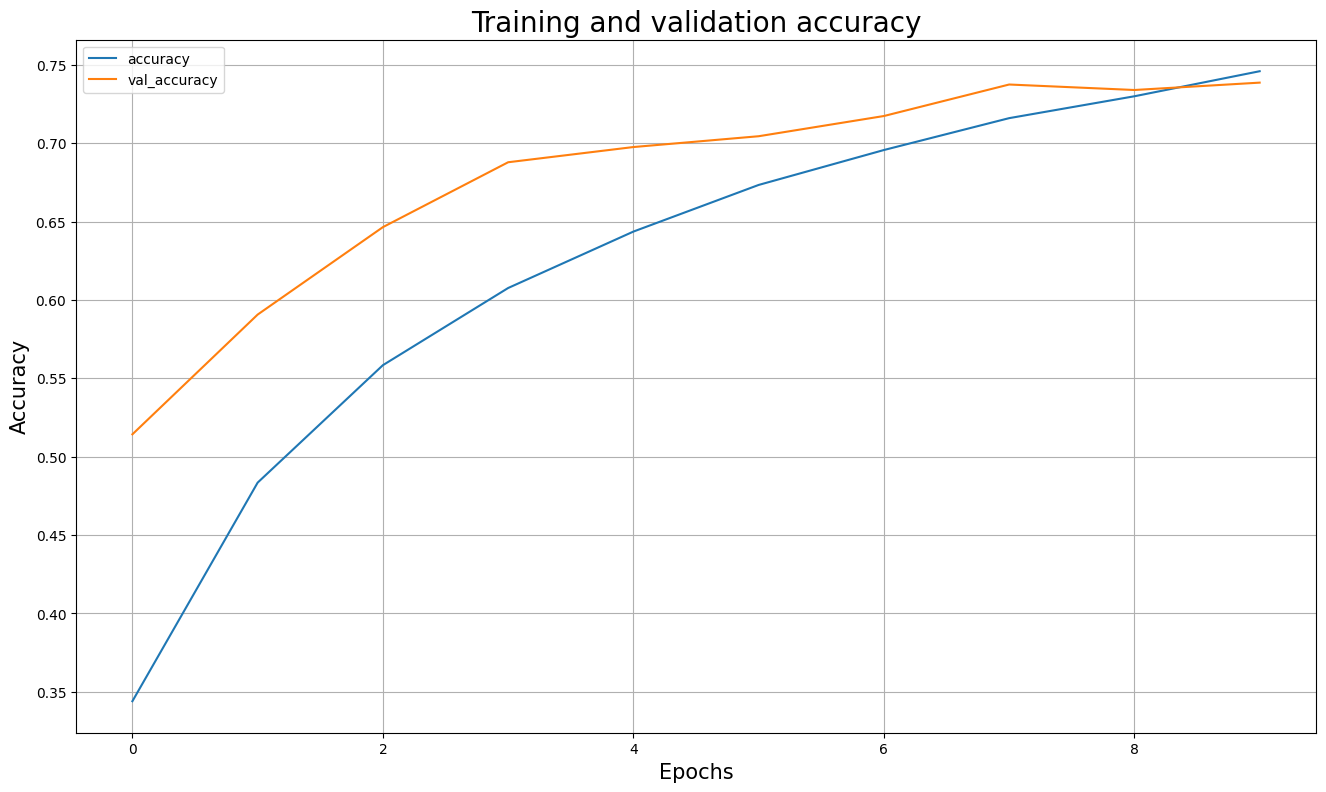

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


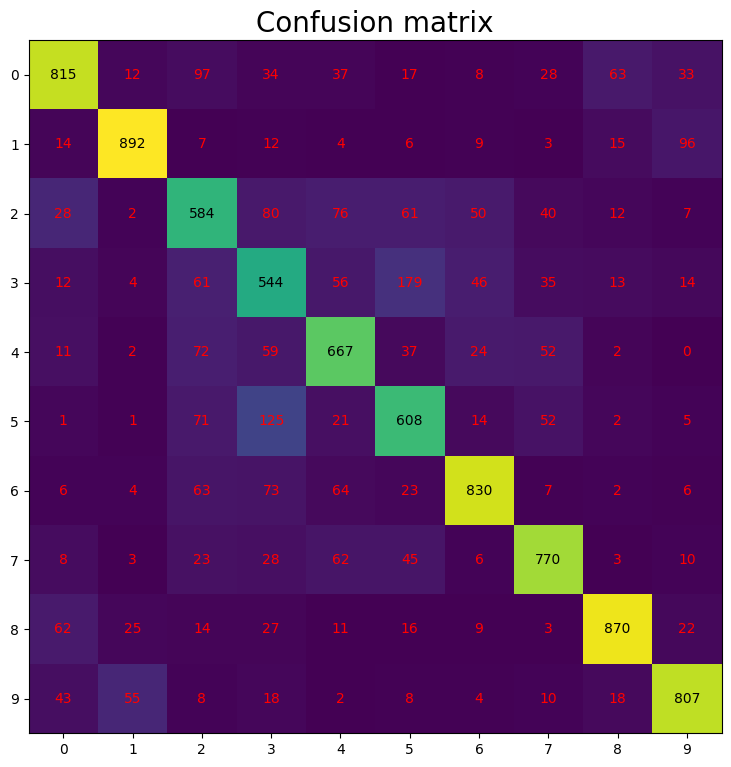

In [8]:
model11 = build_model(type1, stride1)
model11.summary()

model11.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history11 = model11.fit(train_images, train_labels, epochs = 10, 
                    validation_data = (test_images, test_labels))

test_loss11, test_acc11 = model11.evaluate(test_images, test_labels, verbose = 2)
print("Test Loss: {0} - Test Acc: {1}".format(test_loss11, test_acc11))

plot_accuracy(history11)
y_pred11 = model11.predict(test_images)
Y_pred11 = np.argmax(y_pred11, 1) 
mat11 = confusion_matrix(test_labels, Y_pred11)
plot_cofusion_matrix(mat11)

c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2505 - loss: 1.9813 - val_accuracy: 0.4474 - val_loss: 1.4890
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4447 - loss: 1.5119 - val_accuracy: 0.5075 - val_loss: 1.3449
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5048 - loss: 1.3766 - val_accuracy: 0.5423 - val_loss: 1.2672
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5458 - loss: 1.2764 - val_accuracy: 0.5679 - val_loss: 1.1940
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5650 - loss: 1.2216 - val_accuracy: 0.5808 - val_loss: 1.1612
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5907 - loss: 1.1566 - val_accuracy: 0.5791 - val_loss: 1.1580
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6024 - loss: 1.1270 - val_accuracy: 0.5958 - val_loss: 1.1205
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6202 - loss: 1.0886 -

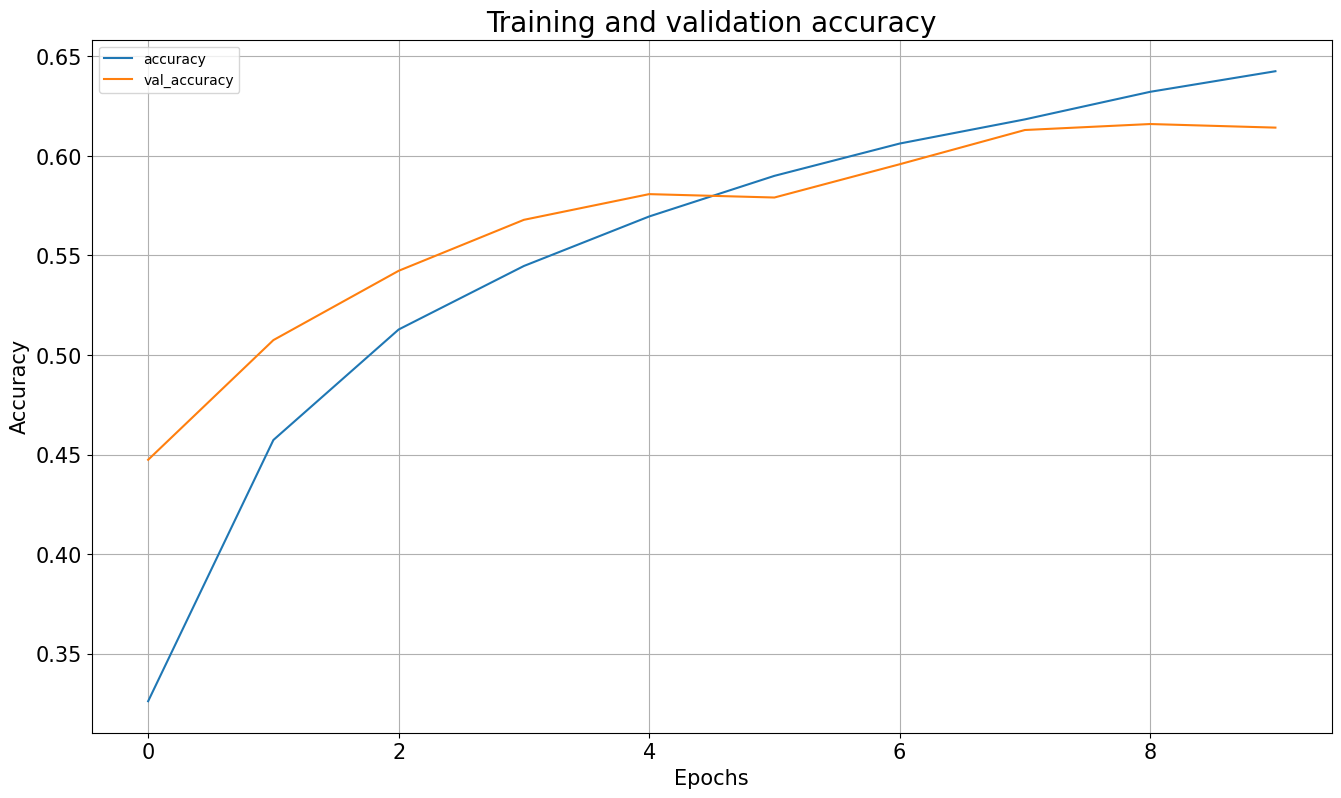

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


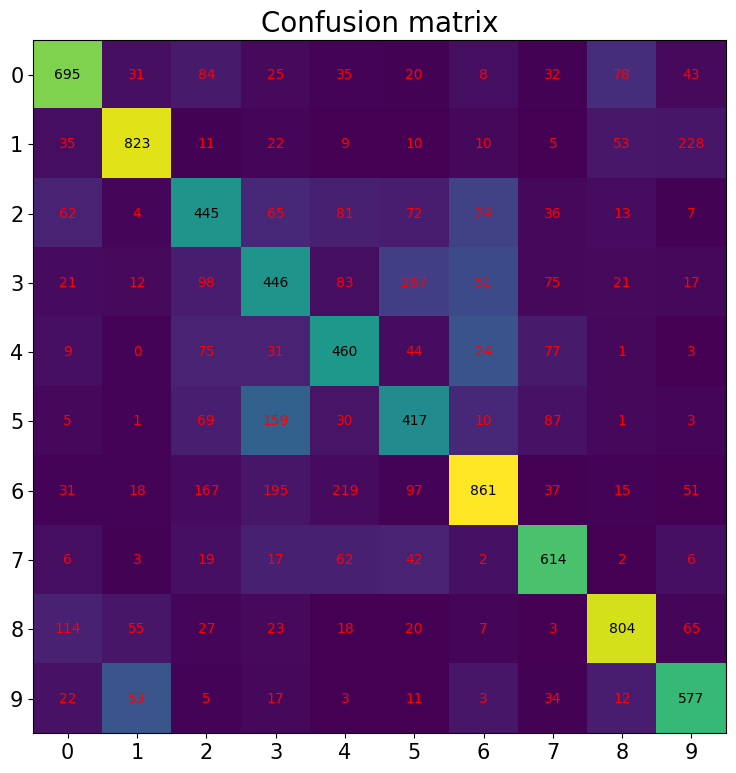

In [9]:
model12 = build_model(type1, stride2)
model12.summary()

model12.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history12 = model12.fit(train_images, train_labels, epochs = 10, 
                    validation_data = (test_images, test_labels))

test_loss12, test_acc12 = model12.evaluate(test_images, test_labels, verbose = 2)
print("Test Loss: {0} - Test Acc: {1}".format(test_loss12, test_acc12))

plot_accuracy(history12)
y_pred12 = model12.predict(test_images)
Y_pred12 = np.argmax(y_pred12, 1) 
mat12 = confusion_matrix(test_labels, Y_pred12)
plot_cofusion_matrix(mat12)

c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.2754 - loss: 1.9303 - val_accuracy: 0.4991 - val_loss: 1.3981
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.4919 - loss: 1.4161 - val_accuracy: 0.5782 - val_loss: 1.2281
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5539 - loss: 1.2635 - val_accuracy: 0.6202 - val_loss: 1.0843
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5961 - loss: 1.1497 - val_accuracy: 0.6371 - val_loss: 1.0324
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6316 - loss: 1.0630 - val_accuracy: 0.6549 - val_loss: 0.9764
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6601 - loss: 0.9740 - val_accuracy: 0.6904 - val_loss: 0.9129
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6839 - loss: 0.9028 - val_accuracy: 0.7009 - val_loss: 0.8716
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6996 -

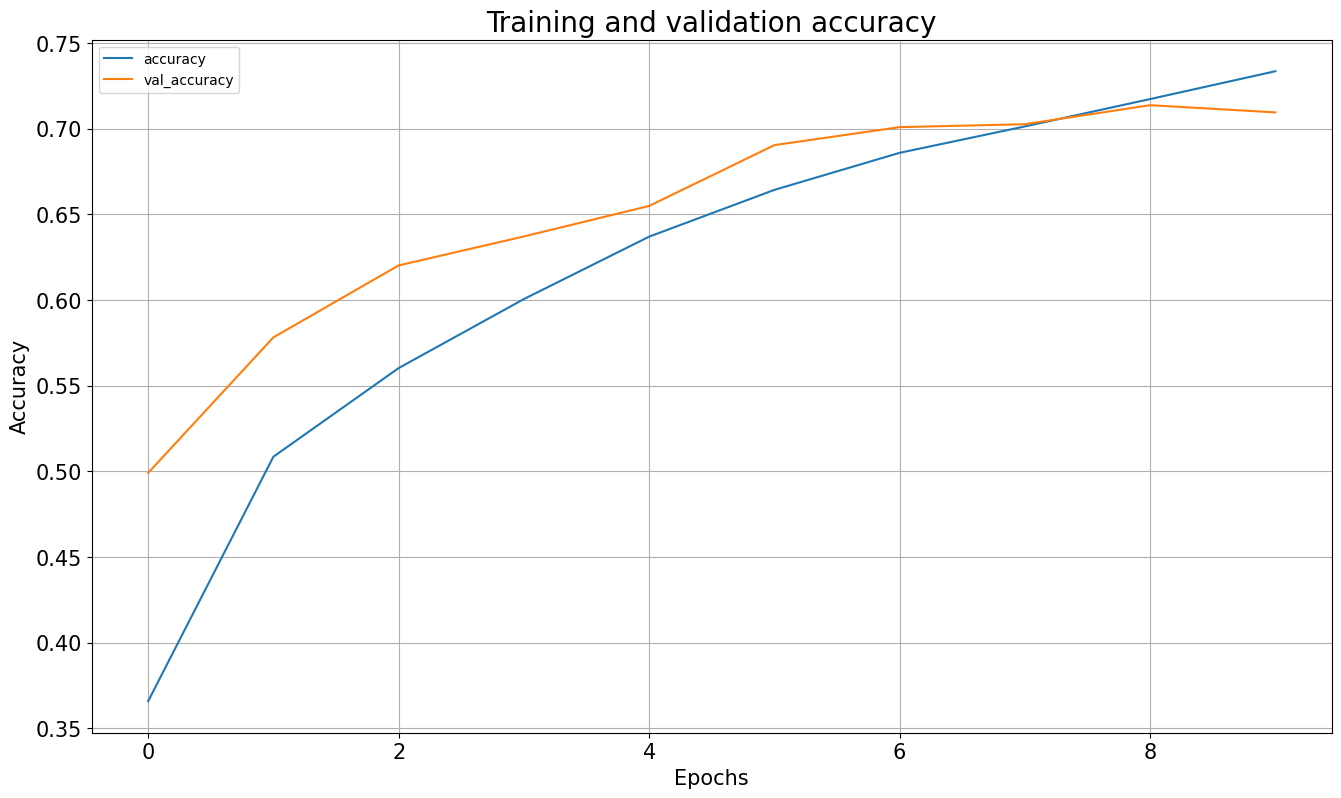

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


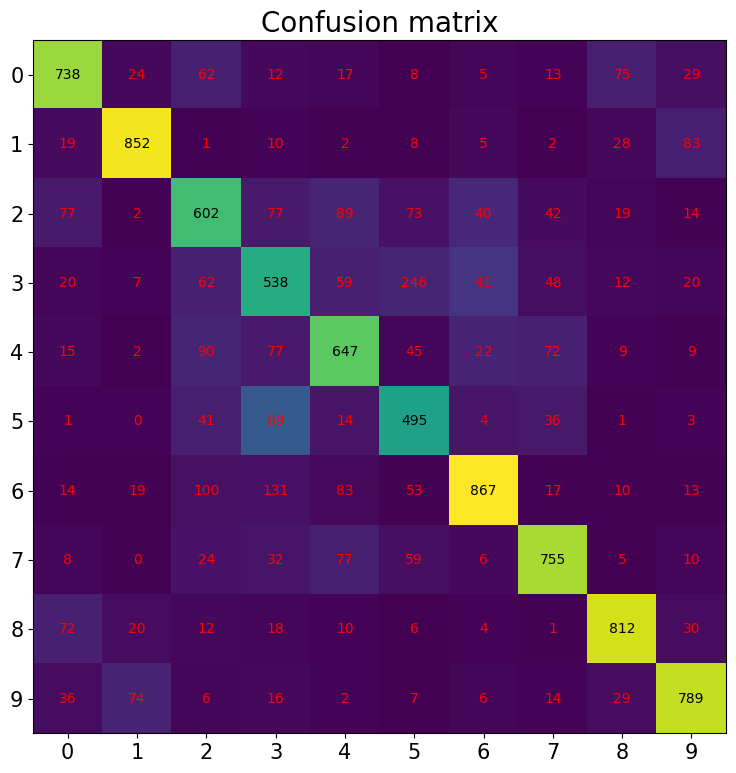

In [10]:
model21 = build_model(type2, stride1)
model21.summary()

model21.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history21 = model21.fit(train_images, train_labels, epochs = 10, 
                    validation_data = (test_images, test_labels))

test_loss21, test_acc21 = model21.evaluate(test_images, test_labels, verbose = 2)
print("Test Loss: {0} - Test Acc: {1}".format(test_loss21, test_acc21))

plot_accuracy(history21)
y_pred21 = model21.predict(test_images)
Y_pred21 = np.argmax(y_pred21, 1) 
mat21 = confusion_matrix(test_labels, Y_pred21)
plot_cofusion_matrix(mat21)

In [11]:
print(f"Accuracy with {type1} padding and strides ({stride1}, {stride1}): {test_acc11},\nAccuracy with {type1} padding and strides ({stride2}, {stride2}): {test_acc12},\nAccuracy with {type2} padding and strides ({stride1}, {stride1}): {test_acc21}.")

Accuracy with same padding and strides (1, 1): 0.7386999726295471,
Accuracy with same padding and strides (2, 2): 0.6141999959945679,
Accuracy with valid padding and strides (1, 1): 0.7095000147819519.


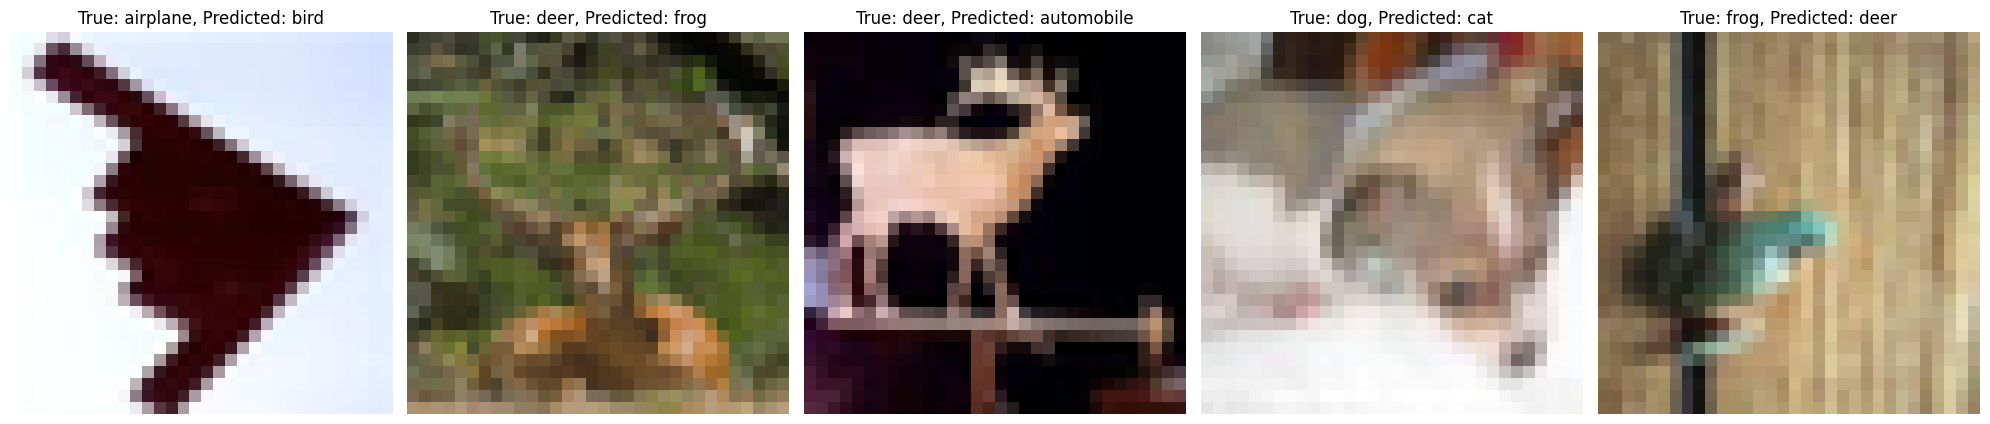

In [12]:
plot_missclassified(Y_pred11)

In [13]:
def build_model_tuner(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding = 'same',
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding = 'same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding = 'same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10))
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [14]:
tuner = RandomSearch(
    build_model_tuner,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
    directory = 'my_dir',
    project_name = 'cifar10_tuner'
)

tuner.search(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels))

best_model = tuner.get_best_models(num_models = 1)[0]

history_best = best_model.fit(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels))

Reloading Tuner from my_dir\cifar10_tuning\tuner0.json



c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.8311 - loss: 0.4696 - val_accuracy: 0.7411 - val_loss: 0.8254
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.8442 - loss: 0.4301 - val_accuracy: 0.7544 - val_loss: 0.8104
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8582 - loss: 0.3924 - val_accuracy: 0.7506 - val_loss: 0.8496
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.8662 - loss: 0.3742 - val_accuracy: 0.7520 - val_loss: 0.8631
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.8731 - loss: 0.3487 - val_accuracy: 0.7562 - val_loss: 0.9048
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.8777 - loss: 0.3321 - val_accuracy: 0.7479 - val_loss: 0.9143
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8860 - loss: 0.3118 - val_accuracy: 0.7432 - val_loss: 0.9534
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.8857 -

313/313 - 4s - 12ms/step - accuracy: 0.7580 - loss: 1.0528
Test Loss: 1.0527774095535278 - Test Acc: 0.7580000162124634


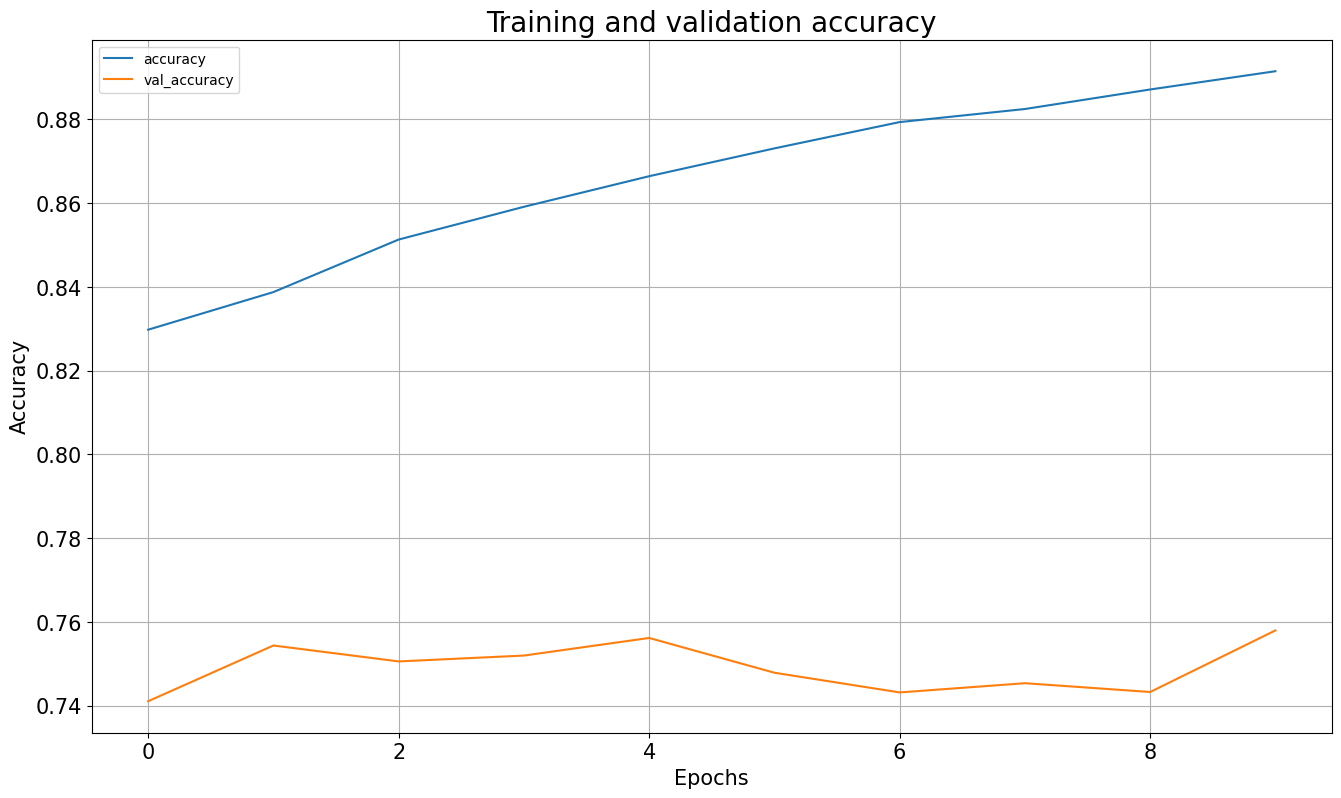

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


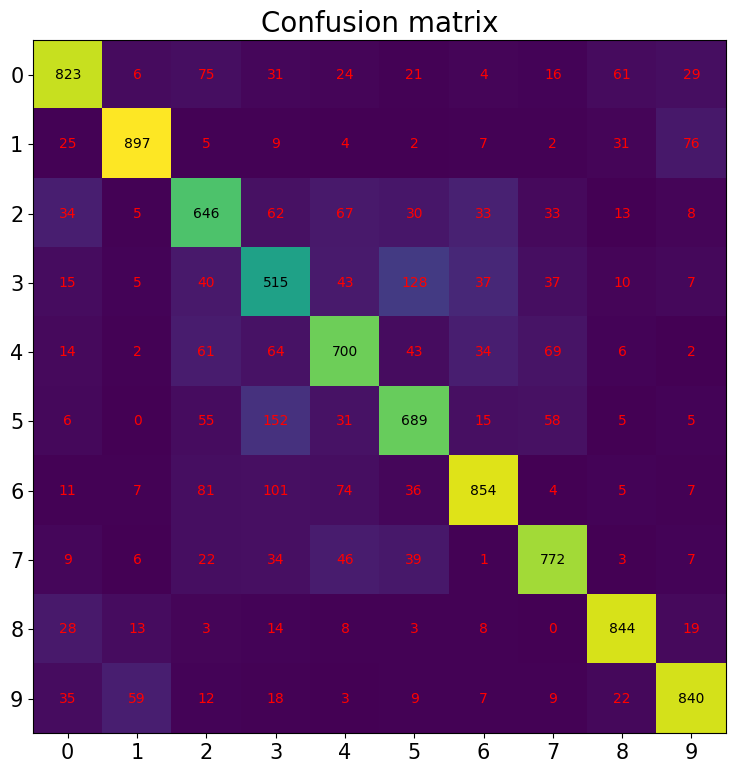

In [15]:
test_loss, test_acc = best_model.evaluate(test_images, test_labels, verbose = 2)
print("Test Loss: {0} - Test Acc: {1}".format(test_loss, test_acc))

plot_accuracy(history_best)
y_pred = best_model.predict(test_images)
Y_pred = np.argmax(y_pred, 1) 
mat = confusion_matrix(test_labels, Y_pred)
plot_cofusion_matrix(mat)